In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from math import log

In [2]:
# Построение графиков
def plot_graph(t, x, y, info):
    # Первый график

    fig = plt.figure(figsize=(10, 5))
    info_str = ""
    for i in str(info).split(","):
        info_str += i.replace("'", "").replace("{", "").replace("}", "")
    plt.title(f'{info_str}', size=17)

    plt.plot(t, x, label="Жертвы (x)")
    plt.plot(t, y, label="Хищники (y)")
    plt.xlabel('t', size=12)
    plt.ylabel('Популяция', size=12)
    plt.legend()
    plt.grid()
    plt.show()

    # Второй график

    fig = plt.figure(figsize=(10, 5))
    info_str = ""
    # Преобразуем словарь info в строку, убираем ненужные символы
    for i in str(info).split(","):
        info_str += i.replace("'", "").replace("{", "").replace("}", "")
    plt.title(f'{info_str}', size=17)
    plt.axis('off')

    ax = fig.add_subplot(121)
    ax.plot(x, y)
    ax.set_xlabel('x', size=12)
    ax.set_ylabel('y', size=12)
    ax.grid()

    ax = fig.add_subplot(122, projection='3d')
    ax.plot(x, y, t)
    ax.set_xlabel('x', size=12)
    ax.set_ylabel('y', size=12)
    ax.set_zlabel('t', size=12)
    ax.grid()

    plt.show()

In [3]:
constants = {  # значения констант
    "alpha": 0.8,  # коэффициент роста жертв
    "beta": 0.1,  # коэффициент взаимодействия хищник-жертва
    "gamma": 1.5,  # коэффициент смерти хищников
    "delta": 0.1,  # коэффициент роста хищников за счет жертв
}

start = {  # начальные условия
    "x0": 40.0,
    "y0": 9.0
}

t_span = [0.0, 4.0]  # интервал интегрирования
n_points = 400

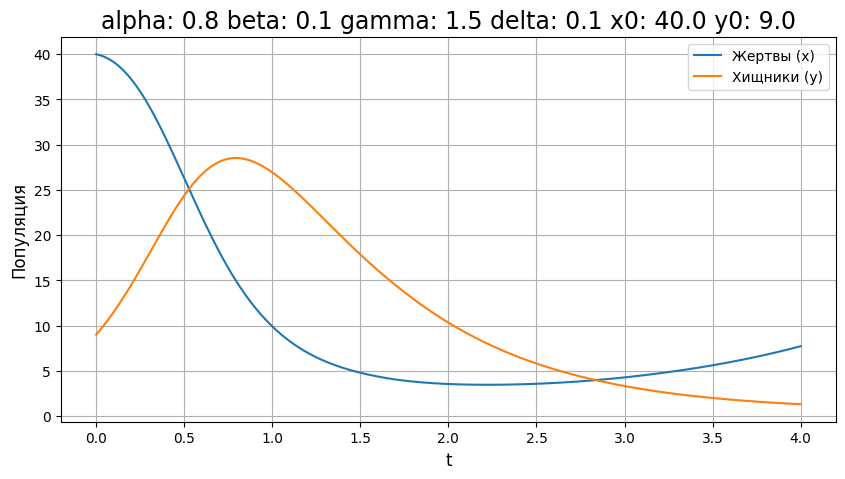

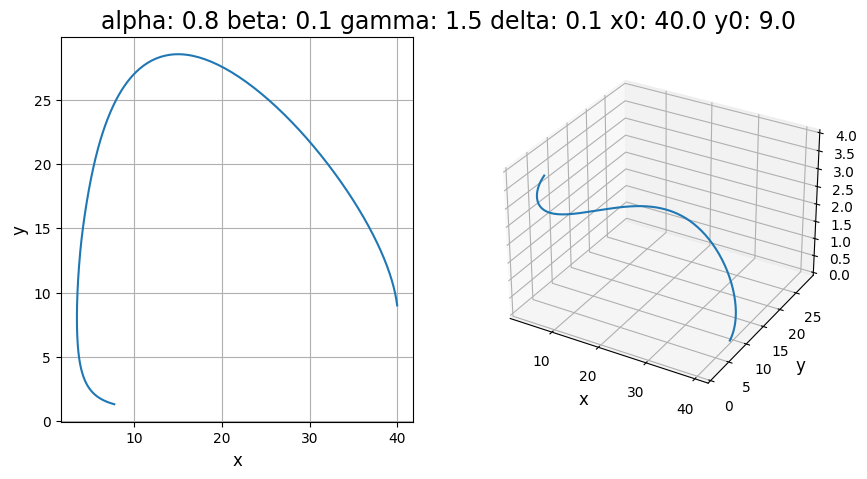

In [4]:
# Задание системы уравнений для построения графика
def system(xy, abcd):
    x, y = xy
    a, b, c, d = abcd
    dxdt = a * x - b * x * y
    dydt = -c * y + d * x * y
    return [dxdt, dydt]


# Решение системы уравнений методом Рунге-Кутты 4-5 порядка
def solve_system(abcd, start, t_span, t_eval, method):
    sol = solve_ivp(lambda t, xy: system(xy, abcd), t_span, start,
                    t_eval=t_eval, method='RK45')
    return sol.t, sol.y

t_eval = np.linspace(t_span[0], t_span[1],
                     n_points)  # создание равномерно распределенного np-массива

t, data = solve_system(list(constants.values()), list(start.values()), t_span,
                       t_eval, 'RK45')
x, y = data
plot_graph(t, x, y, {**constants, **start})

In [5]:
# Функция активации
class mySin(nn.Module):
    def __init__(self, in_features, a=None):
        super(mySin, self).__init__()
        self.in_features = in_features if isinstance(in_features, list) else [
            in_features]
        if a is not None:
            self.a = nn.Parameter(torch.ones(
                self.in_features) * a)  # создать тензор из а
        else:
            m = torch.distributions.exponential.Exponential(
                torch.tensor([0.1]))
            self.a = nn.Parameter((m.rsample(
                self.in_features)).squeeze())

    # Функция активации - синус
    def forward(self, t):
        return torch.sin(t * self.a)


# Определим нейронную сеть
class PINN(nn.Module):
    def __init__(self, n_neuro, a=None):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, n_neuro),  # 1 вход, для t
            mySin(n_neuro, a),
            nn.Linear(n_neuro, n_neuro),  # 3 скрытых слоя
            mySin(n_neuro, a),
            nn.Linear(n_neuro, n_neuro),
            mySin(n_neuro, a),
            nn.Linear(n_neuro, n_neuro),
            mySin(n_neuro, a),
            nn.Linear(n_neuro, 2)  # 2 выхода, один для x(t) и другой для y(t)
        )

    def forward(self, t):
        return self.hidden(t)


# Функция потерь
def loss_function(t, x_pred, y_pred):
    # Вычисление производных
    x_t = (x_pred[1:] - x_pred[:-1]) / (t[1:, 0] - t[:-1, 0])
    y_t = (y_pred[1:] - y_pred[:-1]) / (t[1:, 0] - t[:-1, 0])

    # Уравнения Лотки-Вольтерры
    f1 = x_t - (alpha * x_pred[1:] - beta * x_pred[1:] * y_pred[1:])
    f2 = y_t - (-gamma * y_pred[1:] + delta * x_pred[1:] * y_pred[1:])

    # Потери как среднеквадратичная ошибка уравнений
    loss_f = torch.mean(f1 ** 2) + torch.mean(f2 ** 2)

    # Потери на начальных условиях
    pred_0 = pinn(torch.tensor([[0.0]], dtype=torch.float32,
                               requires_grad=True))  # Важно для градиентов
    x0_pred, y0_pred = pred_0[0, 0], pred_0[
        0, 1]  # Извлекаем жертвы и хищники из тензора

    loss_ic = (x0_pred - x0) ** 2 + (
            y0_pred - y0) ** 2  # Считаем потери для начальных условий

    return loss_f + start_koef * loss_ic

Epoch 0, Loss: 676.0957641601562


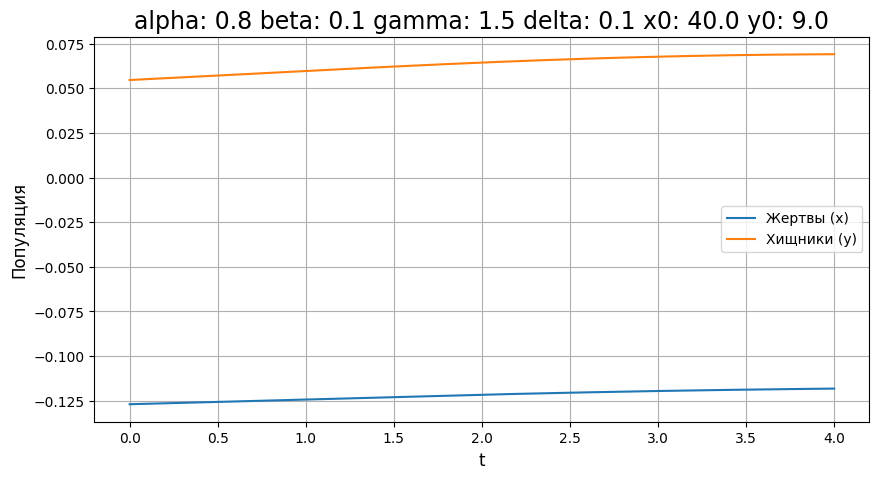

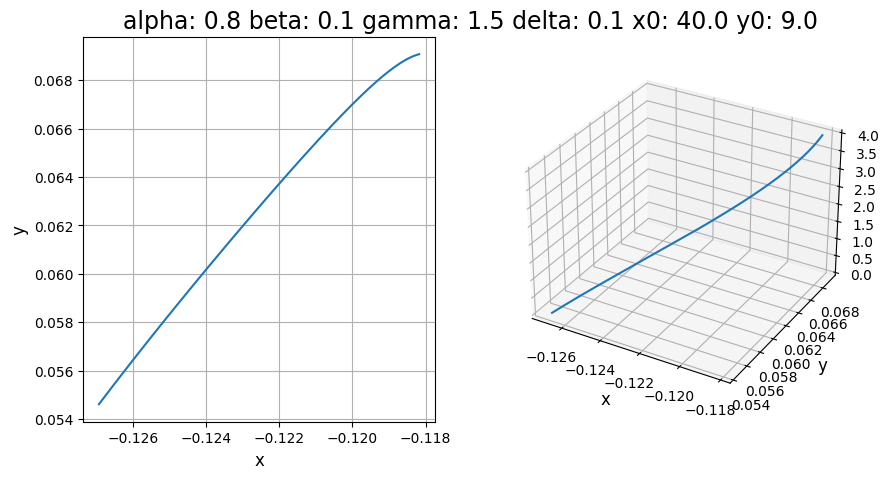

Epoch 200, Loss: 74.37886047363281
Epoch 400, Loss: 4.184051990509033
Epoch 600, Loss: 0.27872759103775024
Epoch 800, Loss: 0.08502618968486786
Epoch 1000, Loss: 0.059336334466934204
Epoch 1200, Loss: 0.04102335497736931
Epoch 1400, Loss: 0.028642278164625168
Epoch 1600, Loss: 0.020494621247053146
Epoch 1800, Loss: 0.0151405343785882
Epoch 2000, Loss: 0.01154735591262579
Epoch 2200, Loss: 0.009055903181433678
Epoch 2400, Loss: 0.007263685576617718
Epoch 2600, Loss: 0.005928420461714268
Epoch 2800, Loss: 0.004906984977424145
Epoch 3000, Loss: 0.004106882959604263
Epoch 3200, Loss: 0.003468560054898262
Epoch 3400, Loss: 0.002952123060822487
Epoch 3600, Loss: 0.0025300090201199055
Epoch 3800, Loss: 0.002180725336074829
Epoch 4000, Loss: 0.001993602840229869
Epoch 4200, Loss: 0.0019835233688354492
Epoch 4400, Loss: 0.001972120488062501
Epoch 4600, Loss: 0.001961653120815754
Epoch 4800, Loss: 0.0019488029647618532


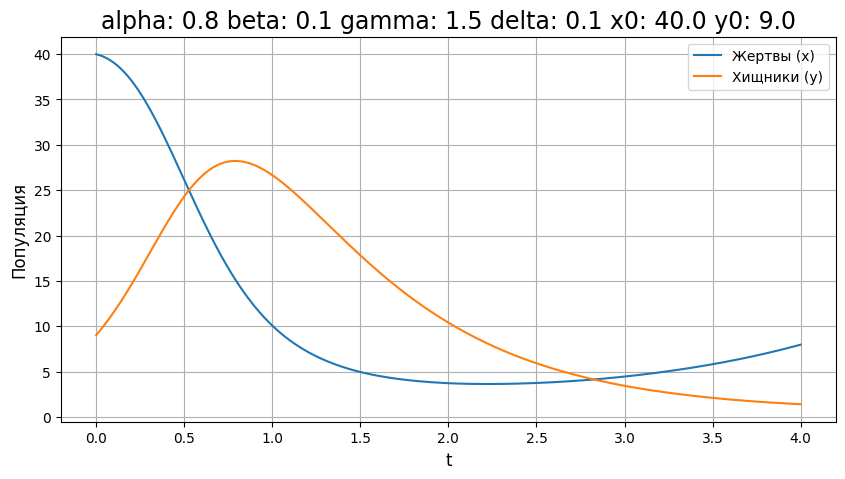

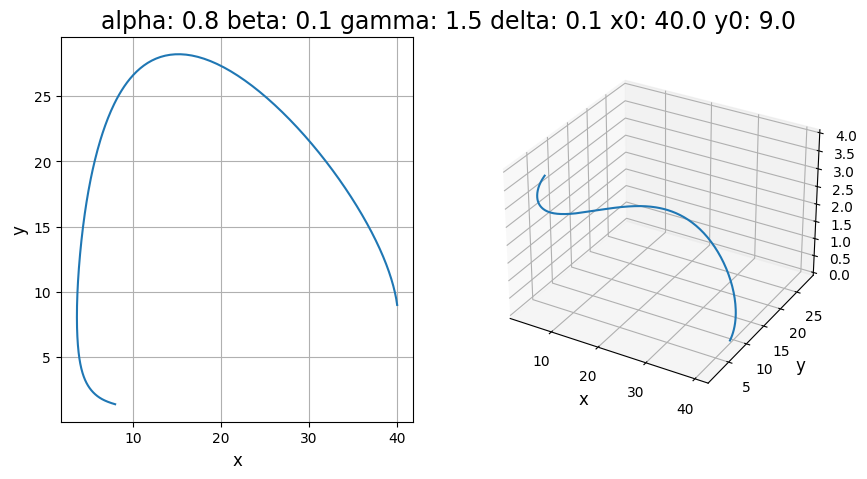

In [71]:
# Параметры системы Лотки-Вольтерры
alpha = constants['alpha']  # коэффициент роста популяции жертвы
beta = constants['beta']  # коэффициент взаимодействия хищника и жертвы
gamma = constants['gamma']  # коэффициент смертности хищника
delta = constants[
    'delta']  # коэффициент размножения хищника за счёт поедания жертвы

# Начальные условия
x0 = start['x0']
y0 = start['y0']

# Промежуток времени моделирования
t_start = t_span[0]
t_end = t_span[1]
t = torch.linspace(t_start, t_end, n_points).reshape(-1, 1)

start_koef = 0.4

# Инициализация сети
pinn = PINN(16, 0.5)
# Коэффициенты сглаживания для оптимизатора
betas = (0.9, 0.999)
eps = 1e-5
# Динамическая настройка скорости обучения, ключи - loss, значения - learning rate
Mepses = {
    # 10: 5e-2,
    1: 5e-3,
    1e-1: 1e-3,
    2e-3: 3e-5,
    1e-4: 1e-7
}
stlr = 1e-2
# Настройка оптимизатора Адама
optimizer = torch.optim.Adam(pinn.parameters(), lr=stlr, betas=betas,
                             eps=eps)

# Обучение модели
n_epochs = 5000
lloss = -1.0
lcnt = 0
losses = []
for epoch in range(n_epochs):

    # Прогноз численности жертв и хищников
    pred = pinn(t)
    x_pred = pred[:, 0]  # Жертвы
    y_pred = pred[:, 1]  # Хищники

    # Вычисление потерь
    loss = loss_function(t, x_pred, y_pred)
    
    runge_lost_linf = max(np.max(np.absolute(np.array(x)- x_pred.detach().numpy())), 
                          np.max(np.absolute(np.array(y) - y_pred.detach().numpy())))

    losses.append((epoch, loss.item(), runge_lost_linf))
    
    # Обратное распространение ошибки
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    if epoch % 5000 == 0:
        plot_graph(t.detach().numpy()[:, 0],
                   x_pred.detach().numpy(),
                   y_pred.detach().numpy(),
                   {**constants, **start})

    nlr = stlr
    for i in Mepses:
        if loss.item() < i:
            nlr = Mepses[i]
    for g in optimizer.param_groups:
        g['lr'] = nlr

    if loss.item() < eps:
        break

# Прогнозируем на обученной модели

pred = pinn(t)
x_pred = pred[:,
         0].detach().numpy()  # Используем .detach() перед преобразованием в numpy
y_pred = pred[:,
         1].detach().numpy()  # Используем .detach() перед преобразованием в numpy
plot_graph(t.detach().numpy()[:, 0], x_pred, y_pred,
           {**constants, **start})

[40.12692808 40.06944371 40.01135969 ...  0.3124808   0.31248271
  0.3124808 ]


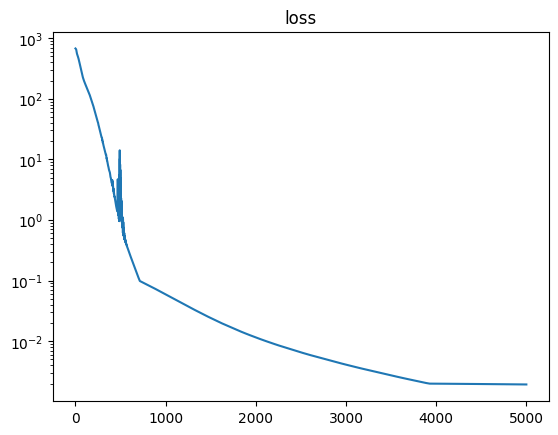

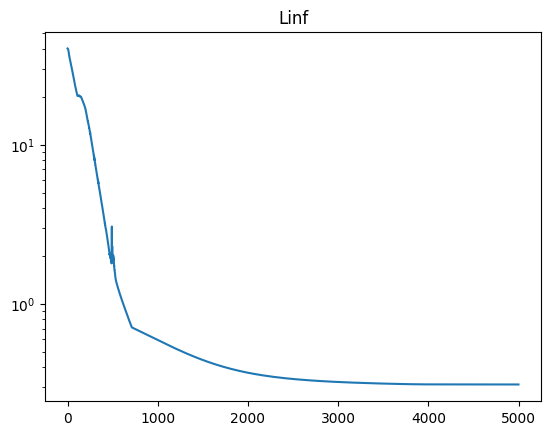

In [72]:
losses = np.array(losses)
print(losses[:, 2])
#print([:, 0])
plt.title('loss')
plt.plot(losses[:, 0], losses[:, 1])
plt.yscale('log')
plt.show()
plt.title('Linf')
plt.plot(losses[:, 0], losses[:, 2])
plt.yscale('log')
plt.show()